In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
cuda = torch.device('cuda')
pretrained_model="./model.pth"

## NET

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
# 初始化网络
model = Net().cuda()
# 加载已经预训练的模型(没gpu没cuda支持的时候加载模型到cpu上计算)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

<All keys matched successfully>

In [7]:
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data_row/', train=False, download=False,
                               transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor()
                               ])),
    batch_size=2000, shuffle=True)

In [8]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data=data.cuda()
            target=target.cuda()
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [9]:
test()

C:\Users\32571\AppData\Local\Temp\ipykernel_20916\4224729980.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
d:\pytorch\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0973, Accuracy: 9688/10000 (97%)



## 随机扰动

In [10]:
def random_noise(image, epsilon=0.2):
    # 通过调整输入图像的每个像素来创建扰动图像
    perturbed_image = image + epsilon * torch.randn_like(image)
    # 添加剪切以维持[0,1]范围
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回被扰动的图像
    return perturbed_image

def random_noise_test(epsilon=.2):
    model.eval()

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data=data.cuda()
        target=target.cuda()

        plt.figure(figsize=(10, 4))
        # 提取第一个数据的灰度图像
        first_data = data[0, 0, :, :].to("cpu")
        # 显示灰度图像
        plt.subplot(1,2,1)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴

        perturbed_data =random_noise(data,epsilon)

        # 提取第一个数据的灰度图像
        first_data = perturbed_data[0, 0, :, :].to("cpu")
        first_data =first_data.detach().numpy()
        # 显示灰度图像
        plt.subplot(1,2,2)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        plt.show()

        output = model(perturbed_data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

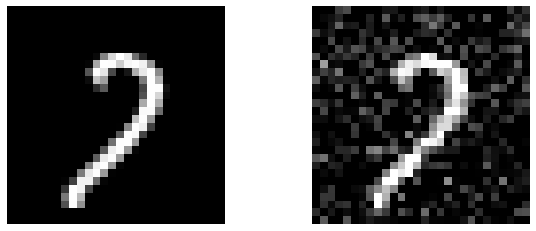

C:\Users\32571\AppData\Local\Temp\ipykernel_20916\4224729980.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


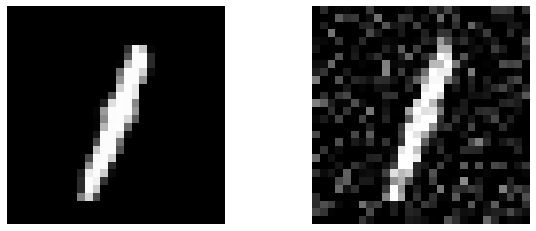

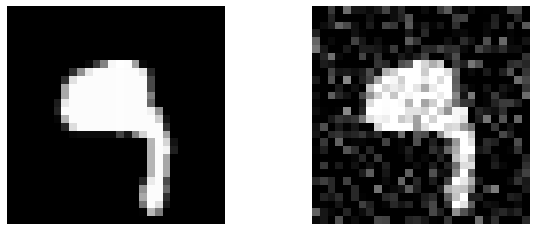

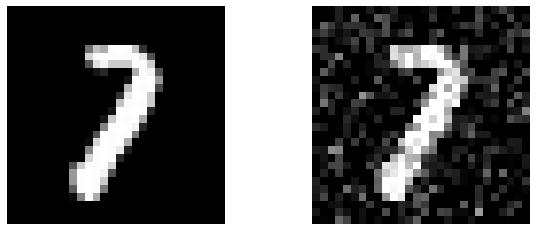

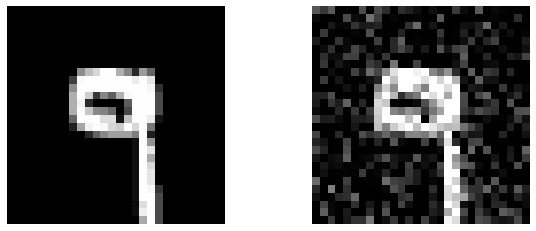


Test set: Avg. loss: 0.1206, Accuracy: 9663/10000 (97%)



In [11]:
random_noise_test()

## FGSM

In [12]:
def fgsm(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def fgsm_test(epsilon=0.07):

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data=data.cuda()
        target=target.cuda()

        plt.figure(figsize=(10, 4))
        # 提取第一个数据的灰度图像
        first_data = data[0, 0, :, :].to("cpu")
        # 显示灰度图像
        plt.subplot(1,2,1)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴

        data.requires_grad=True
        output = model(data)
        # 计算损失
        loss = F.nll_loss(output, target)
        # 将所有现有的渐变归零
        model.zero_grad()
        # 计算后向传递模型的梯度
        loss.backward()
        # 收集datagrad
        data_grad = data.grad.data

        perturbed_data =fgsm(data,epsilon,data_grad)

        # 提取第一个数据的灰度图像
        first_data = perturbed_data[0, 0, :, :].to("cpu")
        first_data =first_data.detach().numpy()
        # 显示灰度图像
        plt.subplot(1,2,2)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        plt.show()

        output = model(perturbed_data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


C:\Users\32571\AppData\Local\Temp\ipykernel_20916\4224729980.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


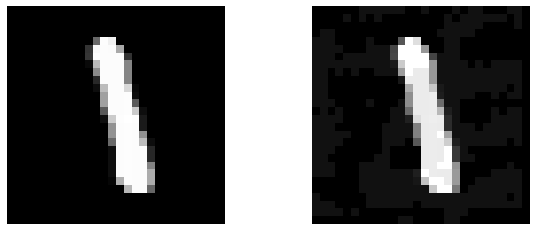

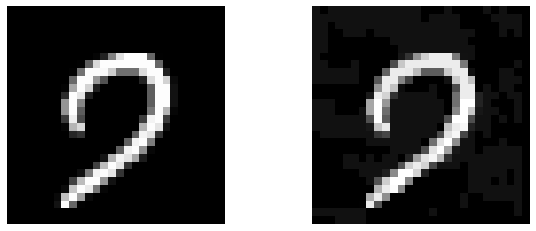

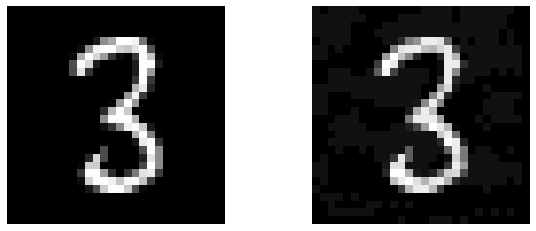

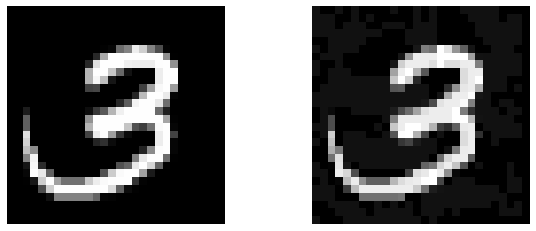

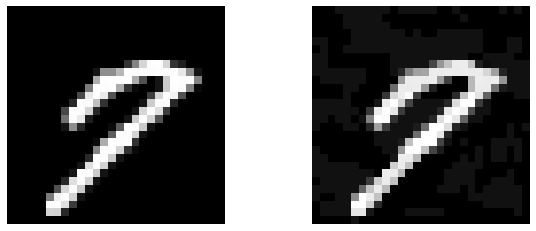


Test set: Avg. loss: 0.3617, Accuracy: 8839/10000 (88%)



In [13]:
model.eval()
fgsm_test()

## PGD

In [14]:
def pgd(model, image, epsilon=0.1, alpha=0.01, num_iter=20):
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True
    
    for _ in range(num_iter):
        model.eval()
        logits = model(perturbed_image)
        predicted_label = logits.argmax(dim=1)  # Get the predicted label

        loss = torch.nn.functional.cross_entropy(logits, predicted_label)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            data_grad = perturbed_image.grad.data
            sign_data_grad = data_grad.sign()

            perturbed_image = perturbed_image + alpha * sign_data_grad
            perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
        perturbed_image.requires_grad = True  # Re-enable gradient computation
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def pgd_test(epsilon=0.45):
    model.eval()

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data=data.cuda()
        target=target.cuda()
        plt.figure(figsize=(10, 4))
        # 提取第一个数据的灰度图像
        first_data = data[0, 0, :, :].to("cpu")
        # 显示灰度图像
        plt.subplot(1,2,1)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        
        perturbed_data =random_noise(data,epsilon=0.01)
        perturbed_data =pgd(model,perturbed_data)

        # 提取第一个数据的灰度图像
        first_data = perturbed_data[0, 0, :, :].to("cpu")
        first_data =first_data.detach().numpy()
        # 显示灰度图像
        plt.subplot(1,2,2)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        plt.show()


        output = model(perturbed_data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

C:\Users\32571\AppData\Local\Temp\ipykernel_20916\4224729980.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


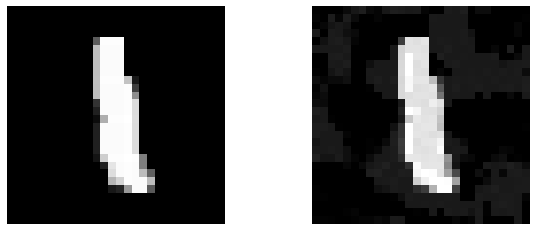

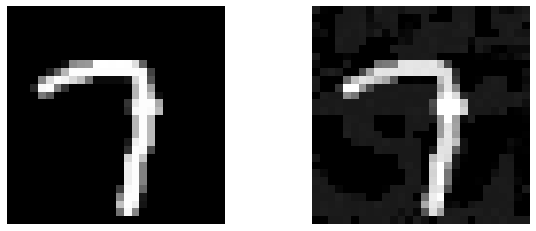

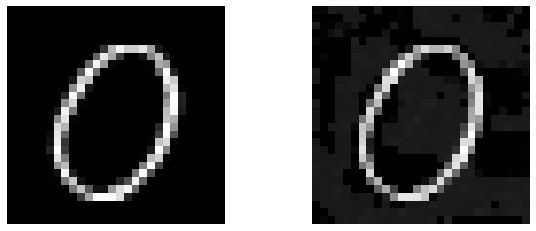

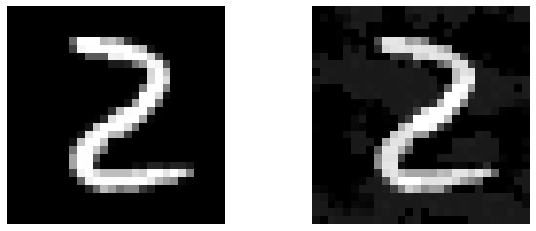

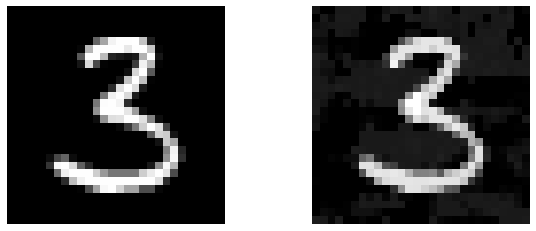


Test set: Avg. loss: 0.3490, Accuracy: 8540/10000 (85%)



In [15]:
pgd_test()

## 带动量的PGD

In [16]:
def m_pgd(model, image, epsilon=0.1, alpha=0.02, num_iter=10 ,momentum_factor=0.2):
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True
    momentum = torch.zeros_like(perturbed_image)

    for _ in range(num_iter):
        model.eval()
        logits = model(perturbed_image)
        predicted_label = logits.argmax(dim=1)  # Get the predicted label

        loss = torch.nn.functional.cross_entropy(logits, predicted_label)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            data_grad = perturbed_image.grad.data
            sign_data_grad = data_grad.sign()

            momentum = momentum_factor * momentum + sign_data_grad
            perturbed_image = perturbed_image + alpha * momentum
            perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
        perturbed_image.requires_grad = True  # Re-enable gradient computation
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def m_pgd_test(epsilon=0.45):
    model.eval()

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data=data.cuda()
        target=target.cuda()
        plt.figure(figsize=(10, 4))
        # 提取第一个数据的灰度图像
        first_data = data[0, 0, :, :].to("cpu")
        # 显示灰度图像
        plt.subplot(1,2,1)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        
        perturbed_data =random_noise(data,epsilon=0.01)
        perturbed_data =m_pgd(model,perturbed_data)

        # 提取第一个数据的灰度图像
        first_data = perturbed_data[0, 0, :, :].to("cpu")
        first_data =first_data.detach().numpy()
        # 显示灰度图像
        plt.subplot(1,2,2)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        plt.show()


        output = model(perturbed_data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

C:\Users\32571\AppData\Local\Temp\ipykernel_20916\4224729980.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


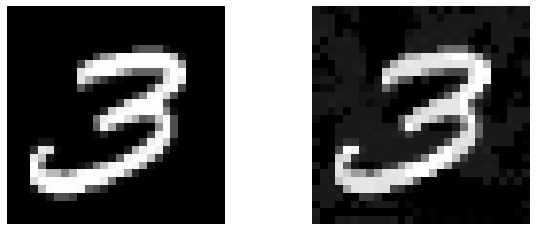

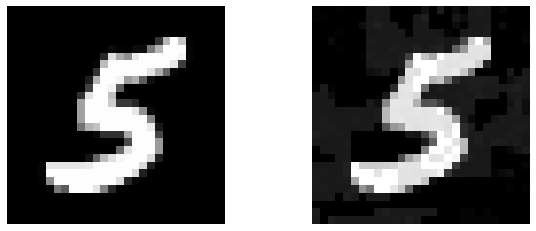

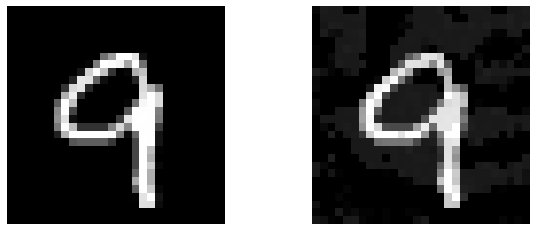

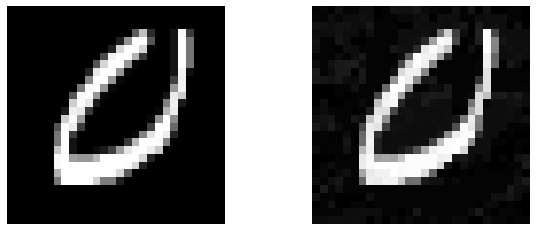

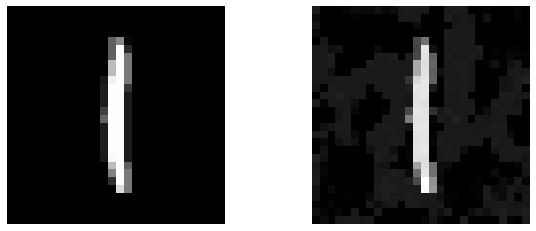


Test set: Avg. loss: 0.3598, Accuracy: 8582/10000 (86%)



In [17]:
m_pgd_test()

## APGD

In [44]:
def apgd(model, image, epsilon=0.13, num_iter=10, p=11):
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True
    
    alpha = 1
    
    for _ in range(num_iter):
        model.eval()
        logits = model(perturbed_image)
        predicted_label = logits.argmax(dim=1)

        loss = torch.nn.functional.cross_entropy(logits, predicted_label)

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            data_grad = perturbed_image.grad.data
            norm_data_grad = data_grad.norm()
            scaled_data_grad = data_grad / (norm_data_grad + 1e-10)

            # Adaptive
            eps_iter = alpha * epsilon / norm_data_grad
            alpha = epsilon * (p - 1) / (p + 1) * alpha + eps_iter

            perturbed_image = perturbed_image + eps_iter * scaled_data_grad
            perturbed_image = torch.max(torch.min(perturbed_image, image + epsilon), image - epsilon)
            perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
        perturbed_image.requires_grad = True  # Re-enable gradient computation
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


def apgd_test():
    model.eval()

    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data=data.cuda()
        target=target.cuda()
        plt.figure(figsize=(10, 4))
        # 提取第一个数据的灰度图像
        first_data = data[0, 0, :, :].to("cpu")
        # 显示灰度图像
        plt.subplot(1,2,1)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        
        perturbed_data =random_noise(data,epsilon=0.01)
        perturbed_data =apgd(model,perturbed_data)

        # 提取第一个数据的灰度图像
        first_data = perturbed_data[0, 0, :, :].to("cpu")
        first_data =first_data.detach().numpy()
        # 显示灰度图像
        plt.subplot(1,2,2)
        plt.imshow(first_data, cmap='gray')
        plt.axis('off')  # 不显示坐标轴
        plt.show()


        output = model(perturbed_data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

C:\Users\32571\AppData\Local\Temp\ipykernel_20916\4224729980.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


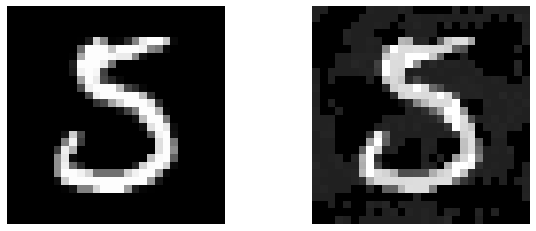

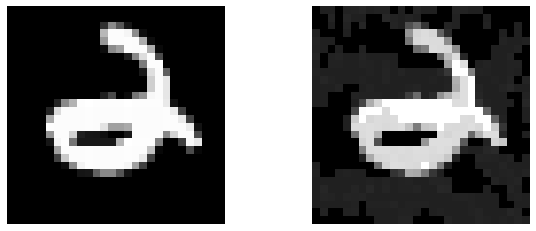

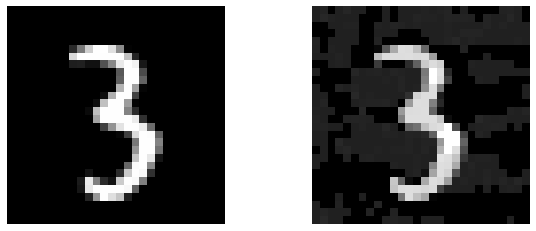

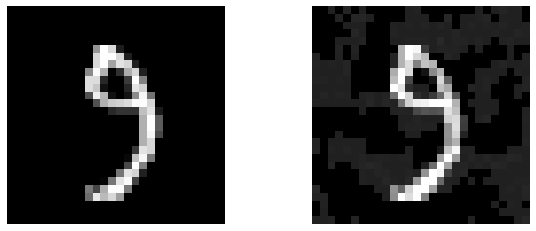

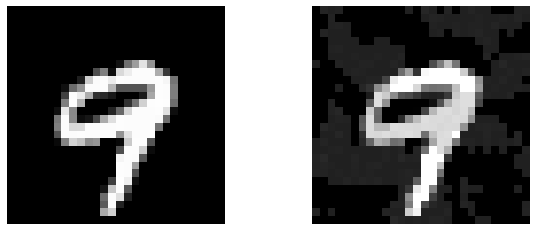


Test set: Avg. loss: 0.5141, Accuracy: 8440/10000 (84%)



In [45]:
apgd_test()